In [ ]:
""" Importing Required Libraries """
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import layers,models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "path to dataset "

In [ ]:
!ls

Dataset  UCMerced_LandUse  UCMerced_LandUse.zip


In [ ]:
""" One time run """
#!unzip "UCMerced_LandUse.zip"

' One time run '

In [ ]:
!ls

Dataset  UCMerced_LandUse  UCMerced_LandUse.zip


Sample Image Experiment

In [ ]:
I = plt.imread("UCMerced_LandUse/Images/agricultural/agricultural00.tif")

(256, 256, 3)


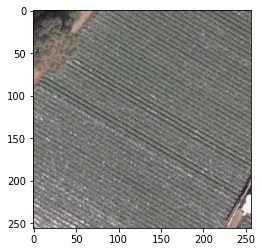

In [ ]:
# Original Image
print(I.shape)
plt.imshow(I)

(256, 256, 3)


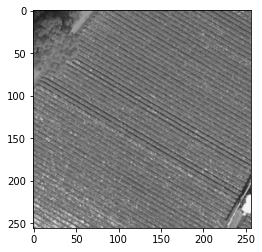

In [ ]:
# gray scale image with same shape
gray_image = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
rgb = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
print(rgb.shape)
plt.imshow(rgb)

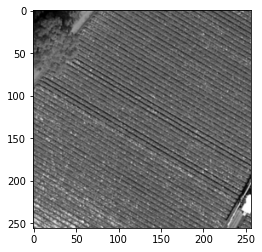

In [ ]:
# normalized image
norm = np.zeros((256, 256,3))
normalize = cv2.normalize(rgb, norm, 0, 255, cv2.NORM_MINMAX)
plt.imshow(normalize)

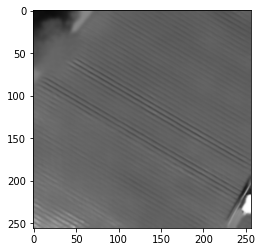

In [ ]:
# Denoise image
filter_image = np.uint8(normalize)
filter_image = cv2.fastNlMeansDenoising(filter_image,None,35.0,7,21)
plt.imshow(filter_image)

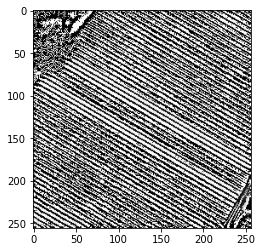

In [ ]:
# Second order derivative
image = ndimage.laplace(filter_image)
image = np.float64(image)
image/=255
plt.imshow(image)

Data Visualization

In [ ]:
class_list = ['agricultural','airplane','baseballdiamond','beach','buildings','chaparral','denseresidential','forest','freeway','golfcourse','harbor','intersection','mediumresidential','mobilehomepark','overpass','parkinglot','river','runway','sparseresidential','storagetanks','tenniscourt']
Images = []
for i in range(21):
  path = "UCMerced_LandUse/Images/" + class_list[i] + "/" + class_list[i] + "00.tif"
  Images.append(plt.imread(path))

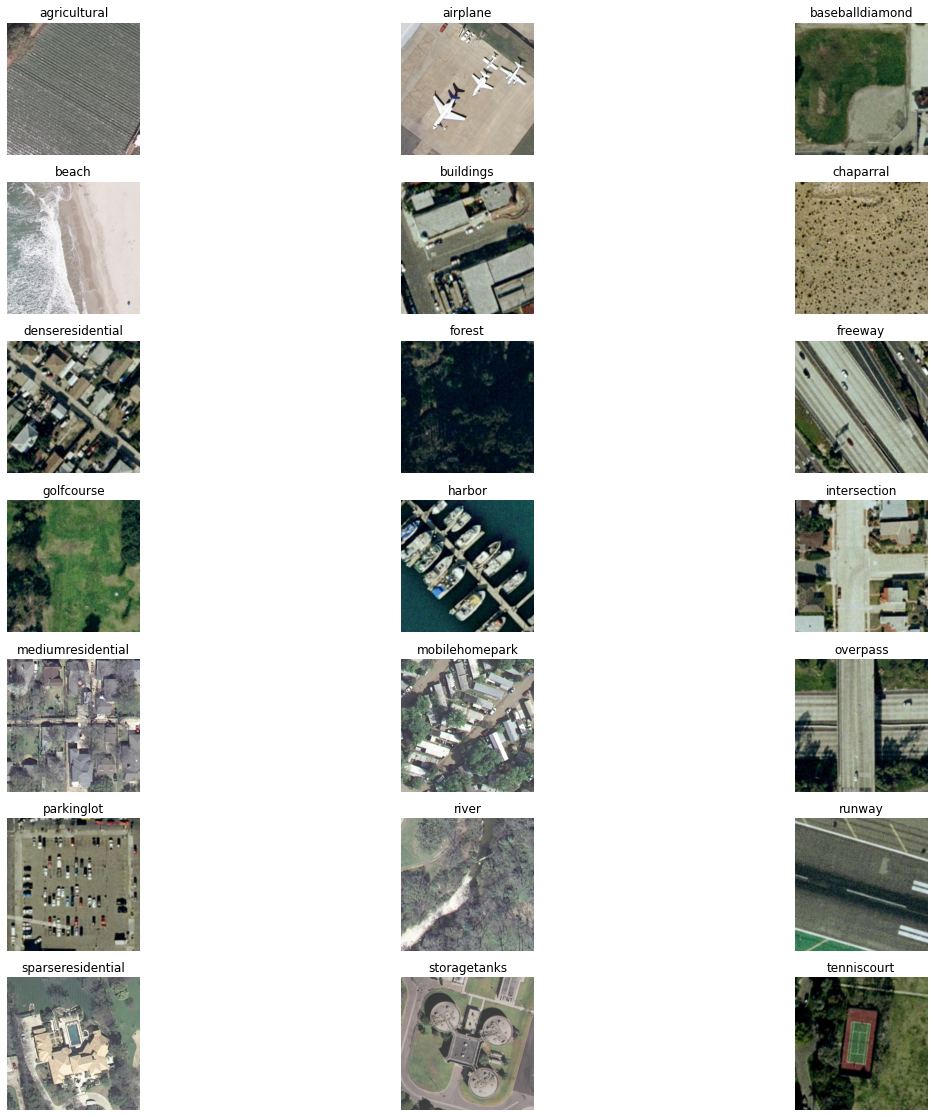

In [ ]:
""" Original Image """
fig = plt.figure(figsize=(20, 20))
rows = 7
columns = 3

for i in range(21):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(Images[i])
  plt.axis('off')
  plt.title(class_list[i])

In [ ]:
""" Preprocessing Function """
def preprocess(image):
  """ Converting image to gray scale and maintaining shape """
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

  """ Normalization """
  norm = np.zeros((256, 256,3))
  image = cv2.normalize(image, norm, 0, 255, cv2.NORM_MINMAX)

  """ Noise removal """
  image = np.uint8(image)
  image = cv2.fastNlMeansDenoising(image,None,35.0,7,21)

  """ Second order derivative """
  image = ndimage.laplace(image)
  image = np.float64(image)
  image/=255

  return image

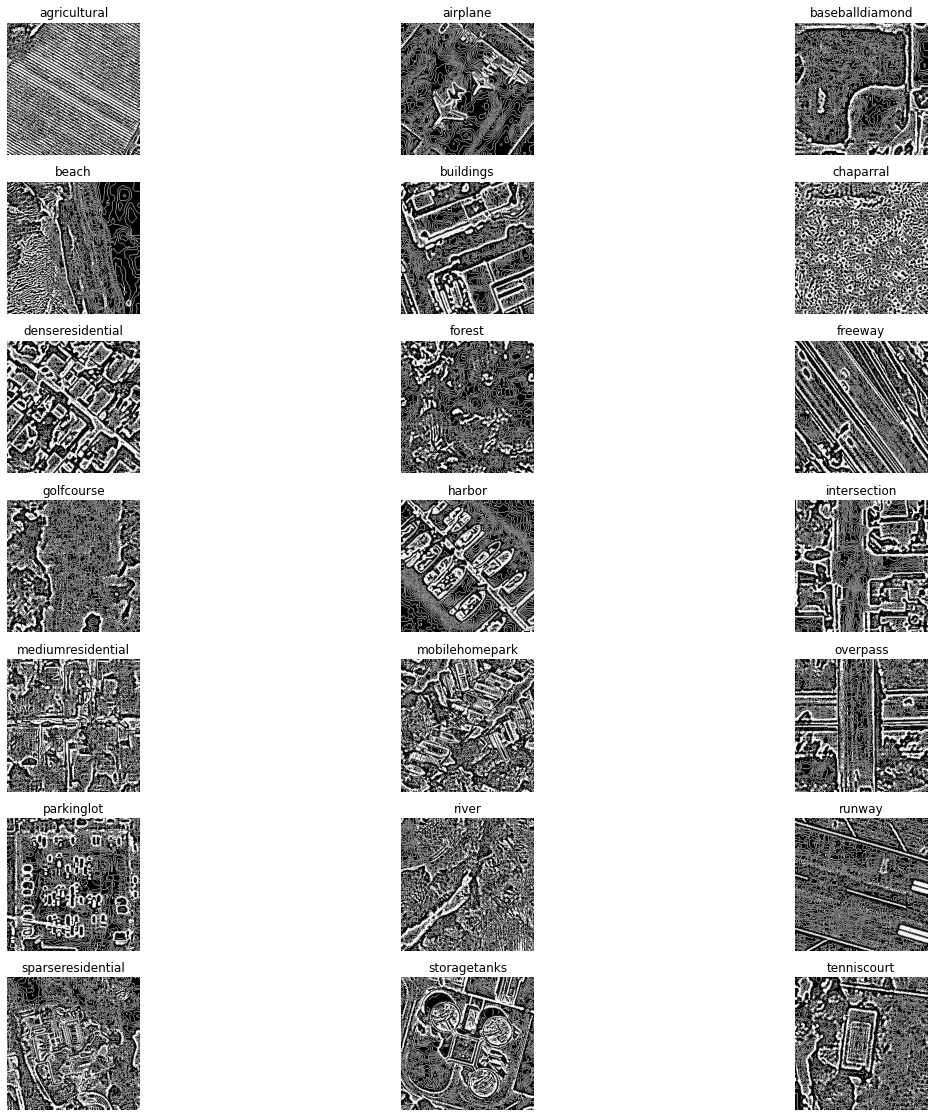

In [ ]:
""" Processed Image """
fig = plt.figure(figsize=(20, 20))
rows = 7
columns = 3

for i in range(21):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(preprocess(Images[i]))
  plt.axis('off')
  plt.title(class_list[i])

Loading and preprocessing dataset

In [ ]:
!pip install split-folders

In [ ]:
""" One time run """
#import splitfolders
#splitfolders.ratio("UCMerced_LandUse/Images",output="Dataset",seed=1000,ratio=(0.8,0.1,0.1))

' One time run '

In [ ]:
!ls

Dataset  UCMerced_LandUse  UCMerced_LandUse.zip


In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess)

In [ ]:
train_data = datagen.flow_from_directory('Dataset/train',target_size=(256,256),batch_size=32,seed=10,class_mode='categorical')

Found 1680 images belonging to 21 classes.


In [ ]:
val_data = datagen.flow_from_directory('Dataset/val',target_size=(256,256),batch_size=32,seed=10,class_mode='categorical')

Found 210 images belonging to 21 classes.


In [ ]:
test_data = datagen.flow_from_directory('Dataset/test',target_size=(256,256),batch_size=4,seed=10,shuffle=False,class_mode='categorical')

Found 210 images belonging to 21 classes.


In [ ]:
batch = next(train_data)

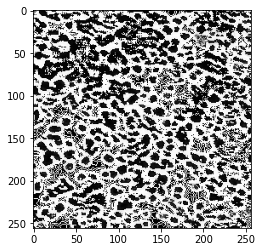

In [ ]:
plt.imshow(batch[0][0])

In [ ]:
index = np.where(batch[1][0]==1)[0][0]
print(class_list[index])

chaparral


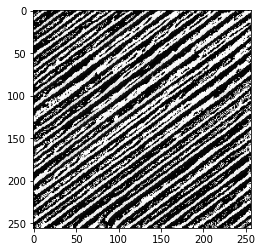

In [ ]:
plt.imshow(batch[0][2])

In [ ]:
index = np.where(batch[1][2]==1)[0][0]
print(class_list[index])

agricultural


RNN + RF model

In [ ]:
rnn_model = models.Sequential()
rnn_model.add(Input(shape=(256,256,3)))

""" Feature Database """
rnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same')) 
rnn_model.add(layers.BatchNormalization())
rnn_model.add(layers.MaxPool2D(pool_size=(3,3)))
rnn_model.add(layers.Dropout(0.25))
rnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same')) 
rnn_model.add(layers.BatchNormalization())
rnn_model.add(layers.MaxPool2D(pool_size=(3,3)))
rnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same')) 
rnn_model.add(layers.BatchNormalization())
rnn_model.add(layers.MaxPool2D(pool_size=(3,3)))
""" RNN Model """
rnn_model.add(layers.Flatten())
rnn_model.add(layers.Dense(64,activation='relu'))
rnn_model.add(layers.Dropout(0.25))
rnn_model.add(layers.Reshape((1, 64)))
rnn_model.add(layers.LSTM(64,activation='relu',return_sequences=True))
rnn_model.add(layers.SimpleRNN(21,activation='tanh'))

In [ ]:
rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_9 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 85, 85, 32)        9248      
                                                                 
 batch_normalization_10 (Bat  (None, 85, 85, 32)      

In [ ]:
from tensorflow.keras.optimizers import Adam
optim = Adam(learning_rate=0.001)
rnn_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [ ]:
history = rnn_model.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
53/53 [==============================] - 853s 16s/step - loss: 7.6000 - accuracy: 0.0476 - val_loss: 9.4222 - val_accuracy: 0.0476
Epoch 2/10
53/53 [==============================] - 538s 10s/step - loss: 7.6244 - accuracy: 0.0405 - val_loss: 8.0034 - val_accuracy: 0.0476
Epoch 3/10
53/53 [==============================] - 528s 10s/step - loss: 7.7983 - accuracy: 0.0351 - val_loss: 7.4959 - val_accuracy: 0.0476
Epoch 4/10
53/53 [==============================] - 530s 10s/step - loss: 7.5807 - accuracy: 0.0429 - val_loss: 7.6919 - val_accuracy: 0.0476
Epoch 5/10
53/53 [==============================] - 532s 10s/step - loss: 7.7240 - accuracy: 0.0387 - val_loss: 7.8365 - val_accuracy: 0.0476
Epoch 6/10
53/53 [==============================] - 533s 10s/step - loss: 7.8659 - accuracy: 0.0429 - val_loss: 7.9004 - val_accuracy: 0.0429
Epoch 7/10
53/53 [==============================] - 529s 10s/step - loss: 7.7292 - accuracy: 0.0435 - val_loss: 8.1970 - val_accuracy: 0.0333
Epoch 

In [ ]:
rnn_model.save("trained_model")

INFO:tensorflow:Assets written to: trained_model/assets


In [ ]:
""" Intermediate Output """
rnn_train_output = rnn_model.predict(train_data)
rnn_val_output = rnn_model.predict(val_data)
rnn_test_output = rnn_model.predict(test_data)

In [ ]:
rnn_train_output.shape

(1680, 21)

In [ ]:
""" Ground Truth """
train_truth = train_data.labels
val_truth = val_data.labels
test_truth = test_data.labels

In [ ]:
train_truth.shape

(1680,)

In [ ]:
print(set(train_truth))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


In [ ]:
""" Random Forest Classification """
classifier = RandomForestClassifier()
classifier.fit(rnn_train_output,train_truth)

RandomForestClassifier()

In [ ]:
train_pred = classifier.predict(rnn_train_output)

In [ ]:
print(set(train_pred))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


In [ ]:
accuracy_score(train_truth,train_pred)

0.9994047619047619

In [ ]:
val_pred = classifier.predict(rnn_val_output)
test_pred = classifier.predict(rnn_test_output)

In [ ]:
accuracy_score(val_truth,val_pred)

0.023809523809523808

In [ ]:
accuracy_score(test_truth,test_pred)

0.06190476190476191

Plotting Results

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

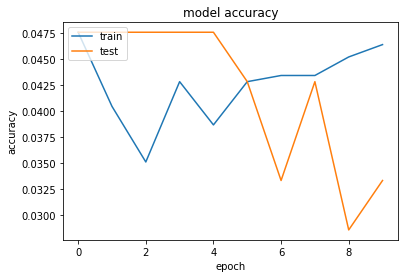

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

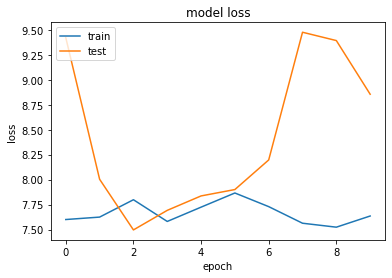

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(train_truth,train_pred)

In [ ]:
print(conf_matrix)

[[79  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  0]
 [ 0  0  0

In [ ]:
def plot_confusion_matrix(cm, 
                          classes,
                          clusters,
                          title = ''):
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    xtick_marks = np.arange(len(clusters))
    ytick_marks = np.arange(len(classes))
    plt.xticks(xtick_marks, clusters, rotation = 90)
    plt.yticks(ytick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

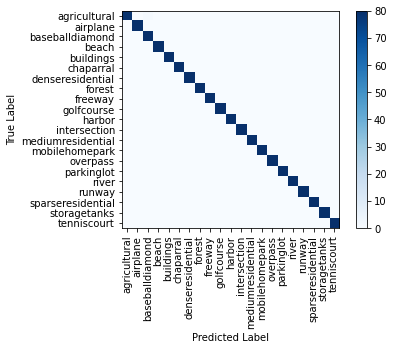

In [ ]:
plot_confusion_matrix(conf_matrix,class_list,class_list)

In [ ]:
precision = precision_score(train_truth,train_pred,average=None)

In [ ]:
print(precision)

[1.         1.         0.98765432 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


In [ ]:
print(np.mean(precision))

0.9994121105232217


In [ ]:
recall = recall_score(train_truth,train_pred,average=None)

In [ ]:
print(recall)

[0.9875 1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.    ]


In [ ]:
print(np.mean(recall))

0.9994047619047619
